In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import LabelEncoder


pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/odi-cricket-matches-19712017/LabelledDataset.csv
/kaggle/input/odi-cricket-matches-19712017/ContinousDataset.csv
/kaggle/input/odi-cricket-matches-19712017/originalDataset.csv
/kaggle/input/odi-cricket-matches-19712017/CategoricalDataset.csv


In [2]:
match_data = pd.read_csv("/kaggle/input/odi-cricket-matches-19712017/ContinousDataset.csv")
x, y = match_data.shape
print("Rows = ",x)
print("Columns = ",y)
match_data.head(5)

Rows =  7494
Columns =  13


,Unnamed: 0,Scorecard,Team 1,Team 2,Margin,Ground,Match Date,Winner,Host_Country,Venue_Team1,Venue_Team2,Innings_Team1,Innings_Team2
0,0,ODI # 1,Australia,England,Winner2ndInning,Melbourne,"Jan 5, 1971",Australia,Australia,Home,Away,Second,First
1,1,ODI # 2,England,Australia,Winner2ndInning,Manchester,"Aug 24, 1972",England,England,Home,Away,Second,First
2,2,ODI # 3,England,Australia,Winner2ndInning,Lord's,"Aug 26, 1972",Australia,England,Home,Away,First,Second
3,3,ODI # 4,England,Australia,Winner2ndInning,Birmingham,"Aug 28, 1972",England,England,Home,Away,Second,First
4,4,ODI # 5,New Zealand,Pakistan,Winner1stInning,Christchurch,"Feb 11, 1973",New Zealand,New Zealand,Home,Away,First,Second


In [3]:
unique_teams = match_data["Winner"].unique()
print(unique_teams)

['Australia' 'England' 'New Zealand' 'West Indies' 'Pakistan' 'India'
 'Sri Lanka' 'Zimbabwe' 'South Africa' 'Kenya' 'U.A.E.' 'Bangladesh'
 'Canada' 'Netherlands' 'Bermuda' 'Ireland' 'Scotland' 'Afghanistan'
 'P.N.G.' 'Hong Kong' 'Namibia' 'U.S.A.' 'East Africa']


In [4]:
len(unique_teams)

23

In [5]:
winner_count = match_data.loc[:,["Winner","Scorecard"]].groupby("Winner").count()
winner_count["Percentage"] = round(winner_count["Scorecard"]*100/x,0);
winner_count = winner_count.sort_values("Scorecard",ascending=False)
winner_count

,Scorecard,Percentage
Winner,,
Australia,1104,15.0
India,950,13.0
Pakistan,932,12.0
West Indies,760,10.0
Sri Lanka,742,10.0
South Africa,722,10.0
England,686,9.0
New Zealand,648,9.0
Zimbabwe,258,3.0


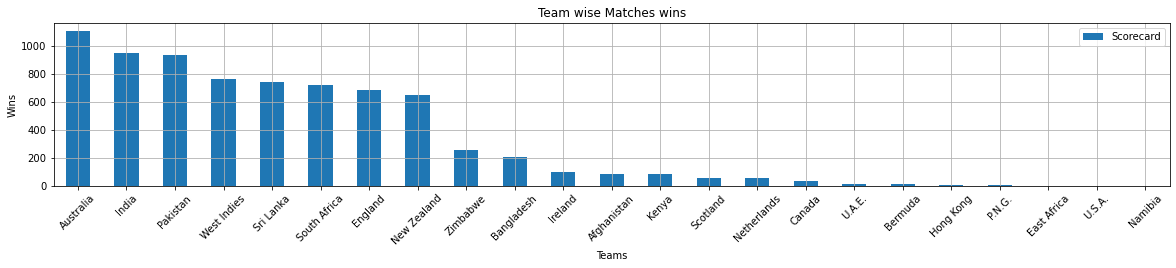

In [6]:
winner_count.iloc[:,0:1].plot(kind="bar",figsize=(20,3))
plt.xticks(rotation=45)
plt.xlabel("Teams")
plt.ylabel("Wins")
plt.title("Team wise Matches wins")
plt.grid()
plt.show()

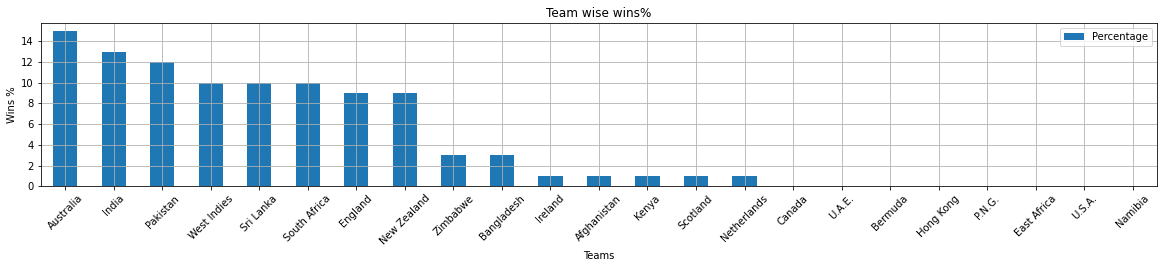

In [7]:
winner_count.iloc[:,1:2].plot(kind="bar",figsize=(20,3))
plt.xticks(rotation=45)
plt.xlabel("Teams")
plt.ylabel("Wins %")
plt.title("Team wise wins%")
plt.grid()
plt.show()

 # **Defined the Data Frame**

In [8]:
team_wise_matches_info = pd.DataFrame(columns=["TeamName","MatchesPlayed","MatchesWon","WonPercentage","LossPercentage","Total_Home_Played","Total_Home_Wins","Home_Wins%","Home_Innings_1st_1st","Home_Innings_1st_2nd","Home_Innings_2nd_1st","Home_Innings_2nd_2nd","Total_Away_Played","Total_Away_Wins","Away_Wins%","Away_Innings_1st_1st","Away_Innings_1st_2nd","Away_Innings_2nd_1st","Away_Innings_2nd_2nd"])

# **Defined the team_statistics function to calculate the team wise statistics and map those statistics to Data Frame**

In [9]:
def team_statistics(team,i):
    #Calculating the total matches played by a team
    total_matches_played = match_data[(match_data["Team 1"] == team) | (match_data["Team 2"] == team)]
    total_matches_played_rows,total_matches_played_columns = total_matches_played.shape
   
    #Calculating the total matches won by a team
    total_matches_won = match_data[((match_data["Team 1"] == team) | (match_data["Team 2"] == team)) & (match_data["Winner"] == team)]
    total_matches_won_rows, total_matches_won_columns = total_matches_won.shape
    
    #Calculating the total matches played by a team at Home Country
    total_home_played = match_data[((match_data["Team 1"] == team) | (match_data["Team 2"] == team)) & (match_data["Host_Country"] == team)]
    total_home_played_rows, total_home_played_columns = total_home_played.shape
    
    #Calculating the total matches won by a team at Home Country
    team_home_won = match_data[((match_data["Team 1"] == team) | (match_data["Team 2"] == team)) & (match_data["Winner"] == team) & (match_data["Host_Country"] == team)]
    team_home_won_rows,team_home_won_columns = team_home_won.shape
    
    #Calculating the total matches won by a team1 in First Innings at Home Country 
    team_home_innings1_1st_country_won = match_data[(match_data["Team 1"] == team) & (match_data["Winner"] == team) & (match_data["Host_Country"] == team) & (match_data["Innings_Team1"] == "First")]
    team_home_innings1_1st_country_won_rows,team_home_innings1_1st_country_won_columns = team_home_innings1_1st_country_won.shape
    
    #Calculating the total matches won by a team1 in Second Innings at Home Country 
    team_home_innings1_2nd_country_won = match_data[(match_data["Team 1"] == team) & (match_data["Winner"] == team) & (match_data["Host_Country"] == team) & (match_data["Innings_Team1"] == "Second")]
    team_home_innings1_2nd_country_won_rows,team_home_innings1_2nd_country_won_columns = team_home_innings1_2nd_country_won.shape
  
    #Calculating the total matches won by a team2 in First Innings at Home Country 
    team_home_innings2_1st_country_won = match_data[(match_data["Team 2"] == team) & (match_data["Winner"] == team) & (match_data["Host_Country"] == team) & (match_data["Innings_Team2"] == "First")]
    team_home_innings2_1st_country_won_rows,team_home_innings2_1st_country_won_columns = team_home_innings2_1st_country_won.shape
    
    #Calculating the total matches won by a team2 in Second Innings at Home Country 
    team_home_innings2_2nd_country_won = match_data[(match_data["Team 2"] == team) & (match_data["Winner"] == team) & (match_data["Host_Country"] == team) & (match_data["Innings_Team2"] == "Second")]
    team_home_innings2_2nd_country_won_rows,team_home_innings2_2nd_country_won_columns = team_home_innings2_2nd_country_won.shape
   
    #Calculating the total matches played by a team at Away Country
    total_away_played = match_data[((match_data["Team 1"] == team) | (match_data["Team 2"] == team)) & (match_data["Host_Country"] != team)]
    total_away_played_rows, total_away_played_columns = total_away_played.shape
    
    #Calculating the total matches won by a team at Away Country
    team_away_won = match_data[((match_data["Team 1"] == team) | (match_data["Team 2"] == team)) & (match_data["Winner"] == team) & (match_data["Host_Country"] != team)]
    team_away_won_rows,team_away_won_columns = team_away_won.shape
    
    #Calculating the total matches won by a team1 in First Innings at Away Country
    team_away_innings1_1st_country_won = match_data[(match_data["Team 1"] == team) & (match_data["Winner"] == team) & (match_data["Host_Country"] != team) & (match_data["Innings_Team1"] == "First")]
    team_away_innings1_1st_country_won_rows,team_away_innings1_1st_country_won_columns = team_away_innings1_1st_country_won.shape
   
    #Calculating the total matches won by a team1 in Second Innings at Away Country 
    team_away_innings1_2nd_country_won = match_data[(match_data["Team 1"] == team) & (match_data["Winner"] == team) & (match_data["Host_Country"] != team) & (match_data["Innings_Team1"] == "Second")]
    team_away_innings1_2nd_country_won_rows,team_away_innings1_2nd_country_won_columns = team_away_innings1_2nd_country_won.shape
    
    #Calculating the total matches won by a team2 in First Innings at Away Country 
    team_away_innings2_1st_country_won = match_data[(match_data["Team 2"] == team) & (match_data["Winner"] == team) & (match_data["Host_Country"] != team) & (match_data["Innings_Team2"] == "First")]
    team_away_innings2_1st_country_won_rows,team_away_innings2_1st_country_won_columns = team_away_innings2_1st_country_won.shape
    
    #Calculating the total matches won by a team2 in Second Innings at Away Country 
    team_away_innings2_2nd_country_won = match_data[(match_data["Team 2"] == team) & (match_data["Winner"] == team) & (match_data["Host_Country"] != team) & (match_data["Innings_Team2"] == "Second")]
    team_away_innings2_2nd_country_won_rows,team_away_innings2_2nd_country_won_columns = team_away_innings2_2nd_country_won.shape
        
    team_wise_matches_info.at[i,"TeamName"] = team
    team_wise_matches_info.at[i,"MatchesPlayed"] = total_matches_played_rows
    team_wise_matches_info.at[i,"MatchesWon"] = total_matches_won_rows
    team_wise_matches_info.at[i,"WonPercentage"] = round(total_matches_won_rows*100/total_matches_played_rows,2)
    team_wise_matches_info.at[i,"LossPercentage"] = 100-round(total_matches_won_rows*100/total_matches_played_rows,2)
    team_wise_matches_info.at[i,"Total_Home_Played"] = total_home_played_rows
    team_wise_matches_info.at[i,"Total_Home_Wins"] = team_home_won_rows
    team_wise_matches_info.at[i,"Home_Innings_1st_1st"] = team_home_innings1_1st_country_won_rows
    team_wise_matches_info.at[i,"Home_Innings_1st_2nd"] = team_home_innings1_2nd_country_won_rows
    team_wise_matches_info.at[i,"Home_Innings_2nd_1st"] = team_home_innings2_1st_country_won_rows
    team_wise_matches_info.at[i,"Home_Innings_2nd_2nd"] = team_home_innings2_2nd_country_won_rows
    team_wise_matches_info.at[i,"Total_Away_Played"] = total_away_played_rows
    team_wise_matches_info.at[i,"Total_Away_Wins"] = team_away_won_rows
    team_wise_matches_info.at[i,"Away_Innings_1st_1st"] = team_away_innings1_1st_country_won_rows
    team_wise_matches_info.at[i,"Away_Innings_1st_2nd"] = team_away_innings1_2nd_country_won_rows
    team_wise_matches_info.at[i,"Away_Innings_2nd_1st"] = team_away_innings2_1st_country_won_rows
    team_wise_matches_info.at[i,"Away_Innings_2nd_2nd"] = team_away_innings2_2nd_country_won_rows
    
    if total_home_played_rows > 0:
         team_wise_matches_info.at[i,"Home_Wins%"] = round(team_home_won_rows*100/total_home_played_rows,2)
    else :
         team_wise_matches_info.at[i,"Home_Wins%"] = 0
            
    if total_away_played_rows > 0:
         team_wise_matches_info.at[i,"Away_Wins%"] = round(team_away_won_rows*100/total_away_played_rows,2)
    else :
         team_wise_matches_info.at[i,"Away_Wins%"] = 0

In [10]:
i=0

for team in unique_teams:
    data = team_statistics(team,i)
    i=i+1   

In [11]:
team_wise_matches_info = team_wise_matches_info.sort_values(["MatchesPlayed","MatchesWon"],ascending=False)
team_wise_matches_info.head()

,TeamName,MatchesPlayed,MatchesWon,WonPercentage,LossPercentage,Total_Home_Played,Total_Home_Wins,Home_Wins%,Home_Innings_1st_1st,Home_Innings_1st_2nd,Home_Innings_2nd_1st,Home_Innings_2nd_2nd,Total_Away_Played,Total_Away_Wins,Away_Wins%,Away_Innings_1st_1st,Away_Innings_1st_2nd,Away_Innings_2nd_1st,Away_Innings_2nd_2nd
5,India,1760,950,53.98,46.02,590,358,60.68,78,101,78,101,1170,592,50.6,132,164,132,164
0,Australia,1718,1104,64.26,35.74,818,548,66.99,159,115,159,115,900,556,61.78,150,128,150,128
4,Pakistan,1708,932,54.57,45.43,330,202,61.21,49,52,49,52,1378,730,52.98,202,163,202,163
6,Sri Lanka,1532,742,48.43,51.57,422,274,64.93,63,74,63,74,1110,468,42.16,128,106,128,106
3,West Indies,1462,760,51.98,48.02,460,258,56.09,50,79,50,79,1002,502,50.1,116,135,116,135


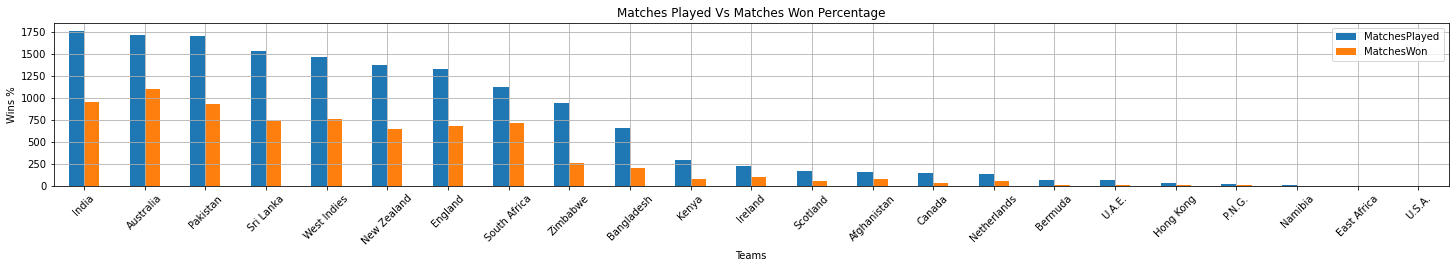

In [12]:
team_wise_matches_info.iloc[:,0:3].plot(kind="bar",x="TeamName",figsize=(25,3))
plt.xticks(rotation=45)
plt.xlabel("Teams")
plt.ylabel("Wins %")
plt.title("Matches Played Vs Matches Won Percentage")
plt.grid()
plt.show()

# **India has played most matches among all the teams**

Text(0.5, 1.0, 'Matches Won Percentage')

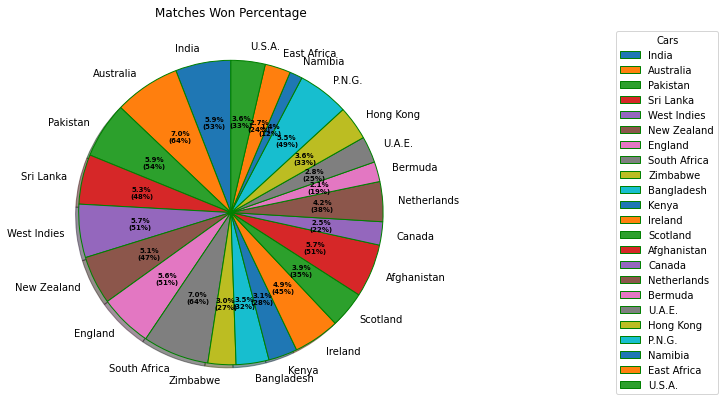

In [13]:
def func(pct, allvalues): 
    absolute = int(pct / 100.*np.sum(allvalues)) 
    return "{:.1f}%\n({:d}%)".format(pct, absolute)

explode = (0.1, 0.0, 0.2, 0.3, 0.0, 0.0) 
wp = { 'linewidth' : 1, 'edgecolor' : "green" } 

fig, ax = plt.subplots(figsize =(10, 7)) 
wedges, texts, autotexts = ax.pie(team_wise_matches_info["WonPercentage"],autopct = lambda pct: func(pct, team_wise_matches_info["WonPercentage"]),labels = team_wise_matches_info["TeamName"],shadow = True,startangle = 90,wedgeprops = wp, textprops = dict(color ="black"))

ax.legend(wedges, team_wise_matches_info["TeamName"],title ="Cars",loc ="center left", bbox_to_anchor =(1.5, 0, 0.5, 1)) 

plt.setp(autotexts, size = 7, weight ="bold") 
ax.set_title("Matches Won Percentage") 

# **Team Wise Winning Percentages**

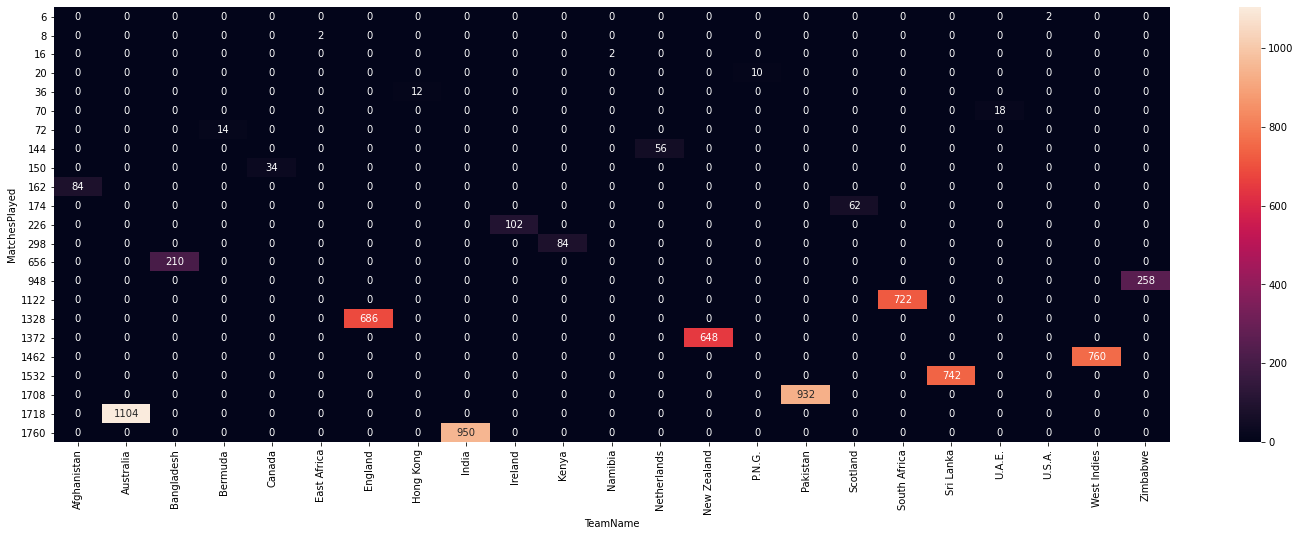

In [14]:
team_wise_matches_info_won_details  = pd.pivot_table(team_wise_matches_info,index=["MatchesPlayed"],columns="TeamName",values="MatchesWon",fill_value=0,aggfunc=sum)
plt.figure(figsize=(25,8))
sns.heatmap(team_wise_matches_info_won_details,annot=True,fmt=".0f")
plt.show()

# **Australia has won the most matches among all the teams**

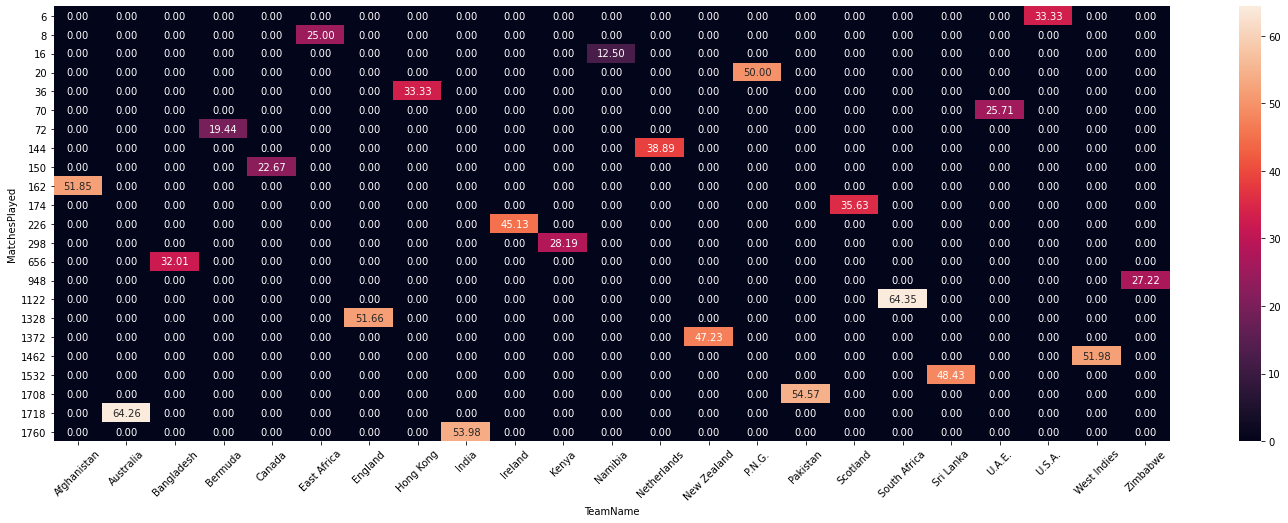

In [15]:
team_wise_matches_info_won_details  = pd.pivot_table(team_wise_matches_info,index=["MatchesPlayed"],columns="TeamName",values="WonPercentage",fill_value=0,aggfunc=sum)
plt.figure(figsize=(25,8))
sns.heatmap(team_wise_matches_info_won_details,annot=True,fmt="1.02f")
plt.xticks(rotation=45)
plt.show()

# ****South Africa has most matches winning % among all the teams****

In [16]:
ground_wise_team_won_data = match_data[match_data["Host_Country"] == "India"].pivot_table(index="Ground",columns="Winner",values="Scorecard",fill_value=0,aggfunc="count")
ground_wise_team_won_data

Winner,Afghanistan,Australia,Bangladesh,Canada,East Africa,England,India,Ireland,Kenya,Namibia,New Zealand,Pakistan,South Africa,Sri Lanka,U.S.A.,West Indies,Zimbabwe
Ground,,,,,,,,,,,,,,,,,
Ahmedabad,0,6,0,0,0,4,14,0,0,0,4,2,4,4,0,10,0
Amritsar,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0
Bengaluru,0,8,0,0,0,4,26,2,0,0,0,2,0,0,0,0,0
Chandigarh,0,2,0,0,0,2,6,0,0,0,0,0,0,0,0,0,0
Chennai,0,8,0,0,0,4,14,0,2,0,2,4,0,0,0,2,0
Cuttack,0,2,0,0,0,6,24,0,0,0,2,0,0,2,0,0,0
Delhi,0,4,0,2,0,4,24,0,0,0,2,2,2,2,0,4,0
Dharamsala,0,0,0,0,0,2,4,0,0,0,0,0,0,0,0,0,0
Faridabad,0,2,0,0,0,0,4,0,0,0,0,0,4,0,0,4,2


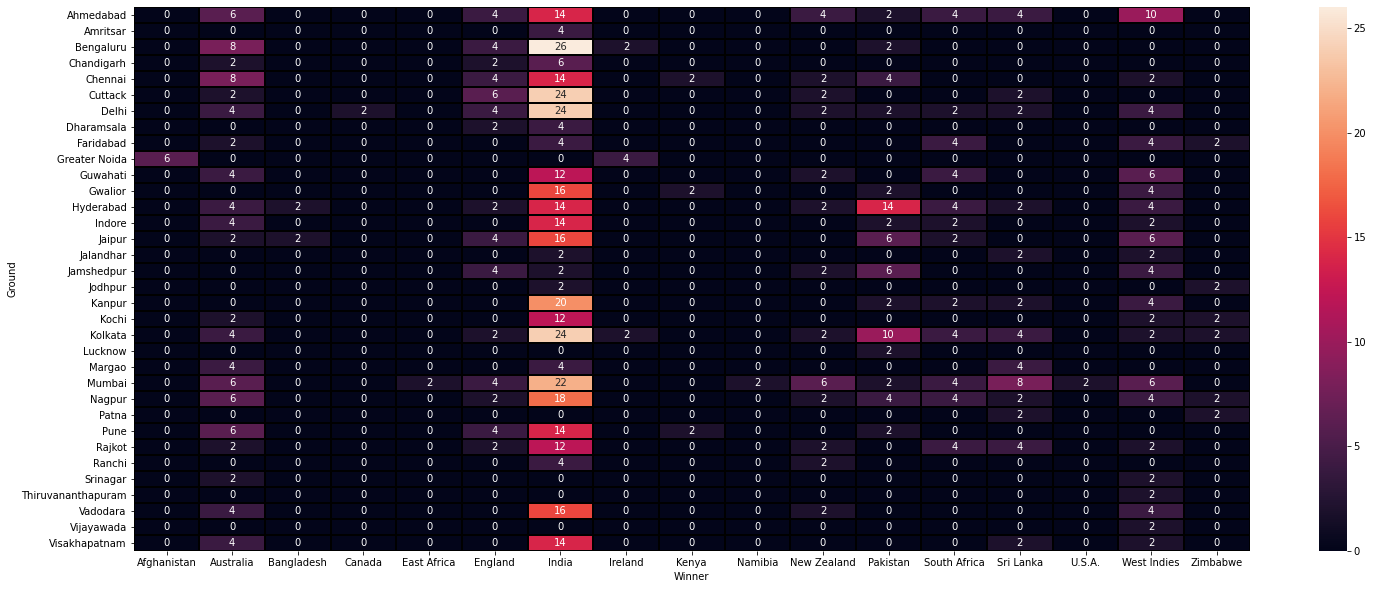

In [17]:
plt.figure(figsize=(25,10))
sns.heatmap(ground_wise_team_won_data,linecolor='black',linewidth=1,annot=True, fmt=".0f")
plt.show()

In [18]:
ground_wise_team_won_data = match_data.pivot_table(index="Ground",columns="Winner",values="Scorecard",fill_value=0,aggfunc="count")
ground_wise_team_won_data

Winner,Afghanistan,Australia,Bangladesh,Bermuda,Canada,East Africa,England,Hong Kong,India,Ireland,Kenya,Namibia,Netherlands,New Zealand,P.N.G.,Pakistan,Scotland,South Africa,Sri Lanka,U.A.E.,U.S.A.,West Indies,Zimbabwe
Ground,,,,,,,,,,,,,,,,,,,,,,,
Aberdeen,0,0,0,0,2,0,2,0,0,2,0,0,0,4,0,0,12,0,0,0,0,0,0
Abu Dhabi,0,6,0,0,0,0,6,2,2,0,0,0,0,8,2,32,2,6,4,4,0,0,0
Adelaide,0,68,2,0,0,0,8,0,16,0,0,0,0,18,0,8,0,8,10,0,0,22,0
Ahmedabad,0,6,0,0,0,0,4,0,14,0,0,0,0,4,0,2,0,4,4,0,0,10,0
Albion,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,8,0
Albury,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
Amritsar,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Amstelveen,4,2,0,0,0,0,0,0,0,8,0,0,6,0,0,2,4,4,4,0,0,0,0
Auckland,0,22,0,0,0,0,10,0,8,0,0,0,0,68,0,10,0,8,6,0,0,8,2


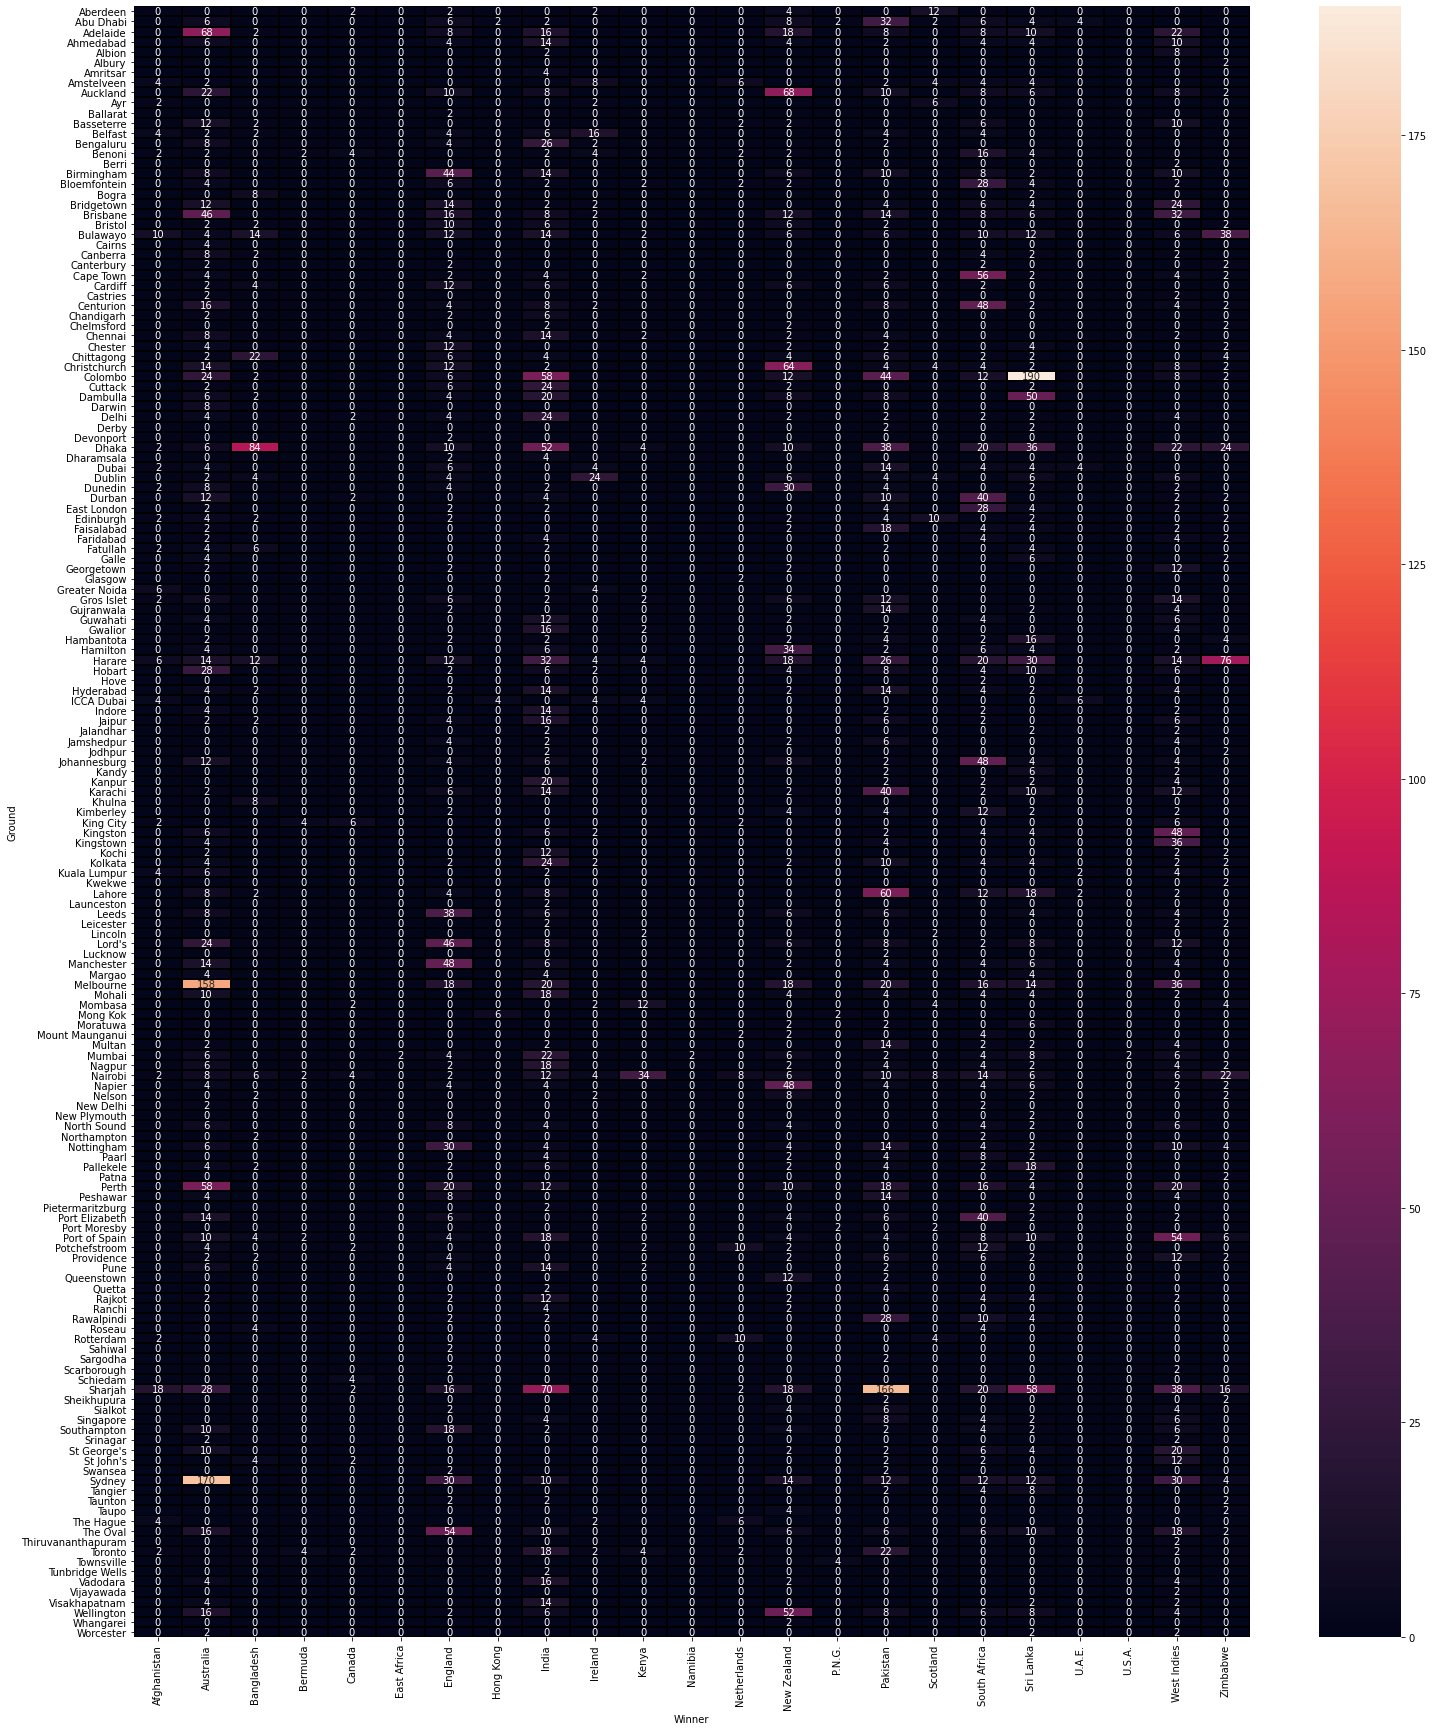

In [19]:
plt.figure(figsize=(25,30))
sns.heatmap(ground_wise_team_won_data,linecolor='black',linewidth=1,annot=True, fmt=".0f")
plt.show()

# **India Won most matches in Banglore**

In [20]:
team_wise_matches_info.head()

,TeamName,MatchesPlayed,MatchesWon,WonPercentage,LossPercentage,Total_Home_Played,Total_Home_Wins,Home_Wins%,Home_Innings_1st_1st,Home_Innings_1st_2nd,Home_Innings_2nd_1st,Home_Innings_2nd_2nd,Total_Away_Played,Total_Away_Wins,Away_Wins%,Away_Innings_1st_1st,Away_Innings_1st_2nd,Away_Innings_2nd_1st,Away_Innings_2nd_2nd
5,India,1760,950,53.98,46.02,590,358,60.68,78,101,78,101,1170,592,50.6,132,164,132,164
0,Australia,1718,1104,64.26,35.74,818,548,66.99,159,115,159,115,900,556,61.78,150,128,150,128
4,Pakistan,1708,932,54.57,45.43,330,202,61.21,49,52,49,52,1378,730,52.98,202,163,202,163
6,Sri Lanka,1532,742,48.43,51.57,422,274,64.93,63,74,63,74,1110,468,42.16,128,106,128,106
3,West Indies,1462,760,51.98,48.02,460,258,56.09,50,79,50,79,1002,502,50.1,116,135,116,135


In [21]:
team_wise_matches_info.sort_values("MatchesPlayed",ascending=False).head(1)

,TeamName,MatchesPlayed,MatchesWon,WonPercentage,LossPercentage,Total_Home_Played,Total_Home_Wins,Home_Wins%,Home_Innings_1st_1st,Home_Innings_1st_2nd,Home_Innings_2nd_1st,Home_Innings_2nd_2nd,Total_Away_Played,Total_Away_Wins,Away_Wins%,Away_Innings_1st_1st,Away_Innings_1st_2nd,Away_Innings_2nd_1st,Away_Innings_2nd_2nd
5,India,1760,950,53.98,46.02,590,358,60.68,78,101,78,101,1170,592,50.6,132,164,132,164


# **India has played most matches among all the teams**

In [22]:
team_wise_matches_info.sort_values("MatchesWon",ascending=False).head(1)

,TeamName,MatchesPlayed,MatchesWon,WonPercentage,LossPercentage,Total_Home_Played,Total_Home_Wins,Home_Wins%,Home_Innings_1st_1st,Home_Innings_1st_2nd,Home_Innings_2nd_1st,Home_Innings_2nd_2nd,Total_Away_Played,Total_Away_Wins,Away_Wins%,Away_Innings_1st_1st,Away_Innings_1st_2nd,Away_Innings_2nd_1st,Away_Innings_2nd_2nd
0,Australia,1718,1104,64.26,35.74,818,548,66.99,159,115,159,115,900,556,61.78,150,128,150,128


# **Australia has won most matches among all the teams**

In [23]:
team_wise_matches_info.sort_values("WonPercentage",ascending=False).head(1)

,TeamName,MatchesPlayed,MatchesWon,WonPercentage,LossPercentage,Total_Home_Played,Total_Home_Wins,Home_Wins%,Home_Innings_1st_1st,Home_Innings_1st_2nd,Home_Innings_2nd_1st,Home_Innings_2nd_2nd,Total_Away_Played,Total_Away_Wins,Away_Wins%,Away_Innings_1st_1st,Away_Innings_1st_2nd,Away_Innings_2nd_1st,Away_Innings_2nd_2nd
8,South Africa,1122,722,64.35,35.65,458,336,73.36,86,82,86,82,664,386,58.13,101,92,101,92


# **South Africa has most winning percentage among all the teams**

In [24]:
team_wise_matches_info.sort_values("Total_Home_Played",ascending=False).head(1)

,TeamName,MatchesPlayed,MatchesWon,WonPercentage,LossPercentage,Total_Home_Played,Total_Home_Wins,Home_Wins%,Home_Innings_1st_1st,Home_Innings_1st_2nd,Home_Innings_2nd_1st,Home_Innings_2nd_2nd,Total_Away_Played,Total_Away_Wins,Away_Wins%,Away_Innings_1st_1st,Away_Innings_1st_2nd,Away_Innings_2nd_1st,Away_Innings_2nd_2nd
0,Australia,1718,1104,64.26,35.74,818,548,66.99,159,115,159,115,900,556,61.78,150,128,150,128


# **Australia has played most matches in home town among all the teams**

In [25]:
team_wise_matches_info.sort_values("Total_Home_Wins",ascending=False).head(1)

,TeamName,MatchesPlayed,MatchesWon,WonPercentage,LossPercentage,Total_Home_Played,Total_Home_Wins,Home_Wins%,Home_Innings_1st_1st,Home_Innings_1st_2nd,Home_Innings_2nd_1st,Home_Innings_2nd_2nd,Total_Away_Played,Total_Away_Wins,Away_Wins%,Away_Innings_1st_1st,Away_Innings_1st_2nd,Away_Innings_2nd_1st,Away_Innings_2nd_2nd
0,Australia,1718,1104,64.26,35.74,818,548,66.99,159,115,159,115,900,556,61.78,150,128,150,128


# **Australia has won most matches in home town among all the teams**

In [26]:
team_wise_matches_info.sort_values("Home_Wins%",ascending=False).head(1)

,TeamName,MatchesPlayed,MatchesWon,WonPercentage,LossPercentage,Total_Home_Played,Total_Home_Wins,Home_Wins%,Home_Innings_1st_1st,Home_Innings_1st_2nd,Home_Innings_2nd_1st,Home_Innings_2nd_2nd,Total_Away_Played,Total_Away_Wins,Away_Wins%,Away_Innings_1st_1st,Away_Innings_1st_2nd,Away_Innings_2nd_1st,Away_Innings_2nd_2nd
19,Hong Kong,36,12,33.33,66.67,8,6,75,2,1,2,1,28,6,21.43,2,1,2,1


# **Hong Kong has won most matches winning percentage in home town among all the teams**

In [27]:
team_wise_matches_info.sort_values("Total_Away_Played",ascending=False).head(1)

,TeamName,MatchesPlayed,MatchesWon,WonPercentage,LossPercentage,Total_Home_Played,Total_Home_Wins,Home_Wins%,Home_Innings_1st_1st,Home_Innings_1st_2nd,Home_Innings_2nd_1st,Home_Innings_2nd_2nd,Total_Away_Played,Total_Away_Wins,Away_Wins%,Away_Innings_1st_1st,Away_Innings_1st_2nd,Away_Innings_2nd_1st,Away_Innings_2nd_2nd
4,Pakistan,1708,932,54.57,45.43,330,202,61.21,49,52,49,52,1378,730,52.98,202,163,202,163


# **Pakistan has played most matches outside [](http://)home town among all the teams**

In [28]:
team_wise_matches_info.sort_values("Total_Away_Wins",ascending=False).head(1)

,TeamName,MatchesPlayed,MatchesWon,WonPercentage,LossPercentage,Total_Home_Played,Total_Home_Wins,Home_Wins%,Home_Innings_1st_1st,Home_Innings_1st_2nd,Home_Innings_2nd_1st,Home_Innings_2nd_2nd,Total_Away_Played,Total_Away_Wins,Away_Wins%,Away_Innings_1st_1st,Away_Innings_1st_2nd,Away_Innings_2nd_1st,Away_Innings_2nd_2nd
4,Pakistan,1708,932,54.57,45.43,330,202,61.21,49,52,49,52,1378,730,52.98,202,163,202,163


# **Pakistan has won most matches outside home town among all the teams**

In [29]:
team_wise_matches_info.sort_values("Away_Wins%",ascending=False).head(1)

,TeamName,MatchesPlayed,MatchesWon,WonPercentage,LossPercentage,Total_Home_Played,Total_Home_Wins,Home_Wins%,Home_Innings_1st_1st,Home_Innings_1st_2nd,Home_Innings_2nd_1st,Home_Innings_2nd_2nd,Total_Away_Played,Total_Away_Wins,Away_Wins%,Away_Innings_1st_1st,Away_Innings_1st_2nd,Away_Innings_2nd_1st,Away_Innings_2nd_2nd
0,Australia,1718,1104,64.26,35.74,818,548,66.99,159,115,159,115,900,556,61.78,150,128,150,128


# **Australia has won most matches winning percentage outside home town among all the teams**

In [30]:
match_data_df = team_wise_matches_info

In [31]:
from sklearn.model_selection import train_test_split
from sklearn import metrics, tree

match_data_df.TeamName = pd.Categorical(match_data_df.TeamName)
match_data_df["TeamName"] = match_data_df.TeamName.cat.codes

match_data_df

,TeamName,MatchesPlayed,MatchesWon,WonPercentage,LossPercentage,Total_Home_Played,Total_Home_Wins,Home_Wins%,Home_Innings_1st_1st,Home_Innings_1st_2nd,Home_Innings_2nd_1st,Home_Innings_2nd_2nd,Total_Away_Played,Total_Away_Wins,Away_Wins%,Away_Innings_1st_1st,Away_Innings_1st_2nd,Away_Innings_2nd_1st,Away_Innings_2nd_2nd
5,8,1760,950,53.98,46.02,590,358,60.68,78,101,78,101,1170,592,50.6,132,164,132,164
0,1,1718,1104,64.26,35.74,818,548,66.99,159,115,159,115,900,556,61.78,150,128,150,128
4,15,1708,932,54.57,45.43,330,202,61.21,49,52,49,52,1378,730,52.98,202,163,202,163
6,18,1532,742,48.43,51.57,422,274,64.93,63,74,63,74,1110,468,42.16,128,106,128,106
3,21,1462,760,51.98,48.02,460,258,56.09,50,79,50,79,1002,502,50.1,116,135,116,135
2,13,1372,648,47.23,52.77,542,324,59.78,74,88,74,88,830,324,39.04,88,74,88,74
1,6,1328,686,51.66,48.34,540,320,59.26,65,95,65,95,788,366,46.45,86,97,86,97
8,17,1122,722,64.35,35.65,458,336,73.36,86,82,86,82,664,386,58.13,101,92,101,92
7,22,948,258,27.22,72.78,378,116,30.69,23,35,23,35,570,142,24.91,39,32,39,32
11,2,656,210,32.01,67.99,312,128,41.03,29,35,29,35,344,82,23.84,19,22,19,22


In [32]:
pred_columns = match_data_df[:]
prediction_var = pred_columns.columns
print(list(prediction_var))

['TeamName', 'MatchesPlayed', 'MatchesWon', 'WonPercentage', 'LossPercentage', 'Total_Home_Played', 'Total_Home_Wins', 'Home_Wins%', 'Home_Innings_1st_1st', 'Home_Innings_1st_2nd', 'Home_Innings_2nd_1st', 'Home_Innings_2nd_2nd', 'Total_Away_Played', 'Total_Away_Wins', 'Away_Wins%', 'Away_Innings_1st_1st', 'Away_Innings_1st_2nd', 'Away_Innings_2nd_1st', 'Away_Innings_2nd_2nd']


In [33]:
train,test = train_test_split(match_data_df,test_size=0.2)
print(train.shape)
print(test.shape)

(18, 19)
(5, 19)


In [34]:
train_X = train[prediction_var]
train_Y = train["TeamName"]
print(list(train.columns))

test_X = train[prediction_var]
test_Y = train["TeamName"]

['TeamName', 'MatchesPlayed', 'MatchesWon', 'WonPercentage', 'LossPercentage', 'Total_Home_Played', 'Total_Home_Wins', 'Home_Wins%', 'Home_Innings_1st_1st', 'Home_Innings_1st_2nd', 'Home_Innings_2nd_1st', 'Home_Innings_2nd_2nd', 'Total_Away_Played', 'Total_Away_Wins', 'Away_Wins%', 'Away_Innings_1st_1st', 'Away_Innings_1st_2nd', 'Away_Innings_2nd_1st', 'Away_Innings_2nd_2nd']


In [35]:
gnb = GaussianNB()
y_pred_gnb = gnb.fit(train_X,train_Y).predict(test_X)

In [36]:
cnf_matrix_gnb = metrics.confusion_matrix(test_Y,y_pred_gnb)
print(cnf_matrix_gnb)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


In [37]:
print(metrics.accuracy_score(test_Y,y_pred_gnb))

1.0


In [38]:
model = RandomForestClassifier(n_estimators=5)
model.fit(train_X,train_Y)
prediction = model.predict(test_X)
print(round(metrics.accuracy_score(test_Y,prediction),2))

0.94


In [39]:
label_df = pd.read_csv("/kaggle/input/odi-cricket-matches-19712017/LabelledDataset.csv")

In [40]:
label_df.head()

,Team 1_Afghanistan,Team 1_Australia,Team 1_Bangladesh,Team 1_Bermuda,Team 1_Canada,Team 1_East Africa,Team 1_England,Team 1_Hong Kong,Team 1_India,Team 1_Ireland,Team 1_Kenya,Team 1_Namibia,Team 1_Netherlands,Team 1_New Zealand,Team 1_P.N.G.,Team 1_Pakistan,Team 1_Scotland,Team 1_South Africa,Team 1_Sri Lanka,Team 1_U.A.E.,Team 1_U.S.A.,Team 1_West Indies,Team 1_Zimbabwe,Team 2_Afghanistan,Team 2_Australia,Team 2_Bangladesh,Team 2_Bermuda,Team 2_Canada,Team 2_East Africa,Team 2_England,Team 2_Hong Kong,Team 2_India,Team 2_Ireland,Team 2_Kenya,Team 2_Namibia,Team 2_Netherlands,Team 2_New Zealand,Team 2_P.N.G.,Team 2_Pakistan,Team 2_Scotland,Team 2_South Africa,Team 2_Sri Lanka,Team 2_U.A.E.,Team 2_U.S.A.,Team 2_West Indies,Team 2_Zimbabwe,Ground_Aberdeen,Ground_Abu Dhabi,Ground_Adelaide,Ground_Ahmedabad,Ground_Albion,Ground_Albury,Ground_Amritsar,Ground_Amstelveen,Ground_Auckland,Ground_Ayr,Ground_Ballarat,Ground_Basseterre,Ground_Belfast,Ground_Bengaluru,Ground_Benoni,Ground_Berri,Ground_Birmingham,Ground_Bloemfontein,Ground_Bogra,Ground_Bridgetown,Ground_Brisbane,Ground_Bristol,Ground_Bulawayo,Ground_Cairns,Ground_Canberra,Ground_Canterbury,Ground_Cape Town,Ground_Cardiff,Ground_Castries,Ground_Centurion,Ground_Chandigarh,Ground_Chelmsford,Ground_Chennai,Ground_Chester,Ground_Chittagong,Ground_Christchurch,Ground_Colombo,Ground_Cuttack,Ground_Dambulla,Ground_Darwin,Ground_Delhi,Ground_Derby,Ground_Devonport,Ground_Dhaka,Ground_Dharamsala,Ground_Dubai,Ground_Dublin,Ground_Dunedin,Ground_Durban,Ground_East London,Ground_Edinburgh,Ground_Faisalabad,Ground_Faridabad,Ground_Fatullah,Ground_Galle,Ground_Georgetown,Ground_Glasgow,Ground_Greater Noida,Ground_Gros Islet,Ground_Gujranwala,Ground_Guwahati,Ground_Gwalior,Ground_Hambantota,Ground_Hamilton,Ground_Harare,Ground_Hobart,Ground_Hove,Ground_Hyderabad,Ground_ICCA Dubai,Ground_Indore,Ground_Jaipur,Ground_Jalandhar,Ground_Jamshedpur,Ground_Jodhpur,Ground_Johannesburg,Ground_Kandy,Ground_Kanpur,Ground_Karachi,Ground_Khulna,Ground_Kimberley,Ground_King City,Ground_Kingston,Ground_Kingstown,Ground_Kochi,Ground_Kolkata,Ground_Kuala Lumpur,Ground_Kwekwe,Ground_Lahore,Ground_Launceston,Ground_Leeds,Ground_Leicester,Ground_Lincoln,Ground_Lord's,Ground_Lucknow,Ground_Manchester,Ground_Margao,Ground_Melbourne,Ground_Mohali,Ground_Mombasa,Ground_Mong Kok,Ground_Moratuwa,Ground_Mount Maunganui,Ground_Multan,Ground_Mumbai,Ground_Nagpur,Ground_Nairobi,Ground_Napier,Ground_Nelson,Ground_New Delhi,Ground_New Plymouth,Ground_North Sound,Ground_Northampton,Ground_Nottingham,Ground_Paarl,Ground_Pallekele,Ground_Patna,Ground_Perth,Ground_Peshawar,Ground_Pietermaritzburg,Ground_Port Elizabeth,Ground_Port Moresby,Ground_Port of Spain,Ground_Potchefstroom,Ground_Providence,Ground_Pune,Ground_Queenstown,Ground_Quetta,Ground_Rajkot,Ground_Ranchi,Ground_Rawalpindi,Ground_Roseau,Ground_Rotterdam,Ground_Sahiwal,Ground_Sargodha,Ground_Scarborough,Ground_Schiedam,Ground_Sharjah,Ground_Sheikhupura,Ground_Sialkot,Ground_Singapore,Ground_Southampton,Ground_Srinagar,Ground_St George's,Ground_St John's,Ground_Swansea,Ground_Sydney,Ground_Tangier,Ground_Taunton,Ground_Taupo,Ground_The Hague,Ground_The Oval,Ground_Thiruvananthapuram,Ground_Toronto,Ground_Townsville,Ground_Tunbridge Wells,Ground_Vadodara,Ground_Vijayawada,Ground_Visakhapatnam,Ground_Wellington,Ground_Whangarei,Ground_Worcester,Innings_Team1_First,Innings_Team1_Second,Innings_Team2_First,Innings_Team2_Second,Venue_Team1_Away,Venue_Team1_Home,Venue_Team1_Neutral,Venue_Team2_Away,Venue_Team2_Home,Venue_Team2_Neutral,Winner
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,A

In [41]:
label_df.isna().sum()

Team 1_Afghanistan           0
Team 1_Australia             0
Team 1_Bangladesh            0
Team 1_Bermuda               0
Team 1_Canada                0
Team 1_East Africa           0
Team 1_England               0
Team 1_Hong Kong             0
Team 1_India                 0
Team 1_Ireland               0
Team 1_Kenya                 0
Team 1_Namibia               0
Team 1_Netherlands           0
Team 1_New Zealand           0
Team 1_P.N.G.                0
Team 1_Pakistan              0
Team 1_Scotland              0
Team 1_South Africa          0
Team 1_Sri Lanka             0
Team 1_U.A.E.                0
Team 1_U.S.A.                0
Team 1_West Indies           0
Team 1_Zimbabwe              0
Team 2_Afghanistan           0
Team 2_Australia             0
Team 2_Bangladesh            0
Team 2_Bermuda               0
Team 2_Canada                0
Team 2_East Africa           0
Team 2_England               0
Team 2_Hong Kong             0
Team 2_India                 0
Team 2_I

In [42]:
lben= LabelEncoder()

label_df["Winner"] = lben.fit_transform(label_df["Winner"])
label_df.head()

,Team 1_Afghanistan,Team 1_Australia,Team 1_Bangladesh,Team 1_Bermuda,Team 1_Canada,Team 1_East Africa,Team 1_England,Team 1_Hong Kong,Team 1_India,Team 1_Ireland,Team 1_Kenya,Team 1_Namibia,Team 1_Netherlands,Team 1_New Zealand,Team 1_P.N.G.,Team 1_Pakistan,Team 1_Scotland,Team 1_South Africa,Team 1_Sri Lanka,Team 1_U.A.E.,Team 1_U.S.A.,Team 1_West Indies,Team 1_Zimbabwe,Team 2_Afghanistan,Team 2_Australia,Team 2_Bangladesh,Team 2_Bermuda,Team 2_Canada,Team 2_East Africa,Team 2_England,Team 2_Hong Kong,Team 2_India,Team 2_Ireland,Team 2_Kenya,Team 2_Namibia,Team 2_Netherlands,Team 2_New Zealand,Team 2_P.N.G.,Team 2_Pakistan,Team 2_Scotland,Team 2_South Africa,Team 2_Sri Lanka,Team 2_U.A.E.,Team 2_U.S.A.,Team 2_West Indies,Team 2_Zimbabwe,Ground_Aberdeen,Ground_Abu Dhabi,Ground_Adelaide,Ground_Ahmedabad,Ground_Albion,Ground_Albury,Ground_Amritsar,Ground_Amstelveen,Ground_Auckland,Ground_Ayr,Ground_Ballarat,Ground_Basseterre,Ground_Belfast,Ground_Bengaluru,Ground_Benoni,Ground_Berri,Ground_Birmingham,Ground_Bloemfontein,Ground_Bogra,Ground_Bridgetown,Ground_Brisbane,Ground_Bristol,Ground_Bulawayo,Ground_Cairns,Ground_Canberra,Ground_Canterbury,Ground_Cape Town,Ground_Cardiff,Ground_Castries,Ground_Centurion,Ground_Chandigarh,Ground_Chelmsford,Ground_Chennai,Ground_Chester,Ground_Chittagong,Ground_Christchurch,Ground_Colombo,Ground_Cuttack,Ground_Dambulla,Ground_Darwin,Ground_Delhi,Ground_Derby,Ground_Devonport,Ground_Dhaka,Ground_Dharamsala,Ground_Dubai,Ground_Dublin,Ground_Dunedin,Ground_Durban,Ground_East London,Ground_Edinburgh,Ground_Faisalabad,Ground_Faridabad,Ground_Fatullah,Ground_Galle,Ground_Georgetown,Ground_Glasgow,Ground_Greater Noida,Ground_Gros Islet,Ground_Gujranwala,Ground_Guwahati,Ground_Gwalior,Ground_Hambantota,Ground_Hamilton,Ground_Harare,Ground_Hobart,Ground_Hove,Ground_Hyderabad,Ground_ICCA Dubai,Ground_Indore,Ground_Jaipur,Ground_Jalandhar,Ground_Jamshedpur,Ground_Jodhpur,Ground_Johannesburg,Ground_Kandy,Ground_Kanpur,Ground_Karachi,Ground_Khulna,Ground_Kimberley,Ground_King City,Ground_Kingston,Ground_Kingstown,Ground_Kochi,Ground_Kolkata,Ground_Kuala Lumpur,Ground_Kwekwe,Ground_Lahore,Ground_Launceston,Ground_Leeds,Ground_Leicester,Ground_Lincoln,Ground_Lord's,Ground_Lucknow,Ground_Manchester,Ground_Margao,Ground_Melbourne,Ground_Mohali,Ground_Mombasa,Ground_Mong Kok,Ground_Moratuwa,Ground_Mount Maunganui,Ground_Multan,Ground_Mumbai,Ground_Nagpur,Ground_Nairobi,Ground_Napier,Ground_Nelson,Ground_New Delhi,Ground_New Plymouth,Ground_North Sound,Ground_Northampton,Ground_Nottingham,Ground_Paarl,Ground_Pallekele,Ground_Patna,Ground_Perth,Ground_Peshawar,Ground_Pietermaritzburg,Ground_Port Elizabeth,Ground_Port Moresby,Ground_Port of Spain,Ground_Potchefstroom,Ground_Providence,Ground_Pune,Ground_Queenstown,Ground_Quetta,Ground_Rajkot,Ground_Ranchi,Ground_Rawalpindi,Ground_Roseau,Ground_Rotterdam,Ground_Sahiwal,Ground_Sargodha,Ground_Scarborough,Ground_Schiedam,Ground_Sharjah,Ground_Sheikhupura,Ground_Sialkot,Ground_Singapore,Ground_Southampton,Ground_Srinagar,Ground_St George's,Ground_St John's,Ground_Swansea,Ground_Sydney,Ground_Tangier,Ground_Taunton,Ground_Taupo,Ground_The Hague,Ground_The Oval,Ground_Thiruvananthapuram,Ground_Toronto,Ground_Townsville,Ground_Tunbridge Wells,Ground_Vadodara,Ground_Vijayawada,Ground_Visakhapatnam,Ground_Wellington,Ground_Whangarei,Ground_Worcester,Innings_Team1_First,Innings_Team1_Second,Innings_Team2_First,Innings_Team2_Second,Venue_Team1_Away,Venue_Team1_Home,Venue_Team1_Neutral,Venue_Team2_Away,Venue_Team2_Home,Venue_Team2_Neutral,Winner
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1

In [43]:
labels = label_df.pop("Winner")

In [44]:
label_df.head()

,Team 1_Afghanistan,Team 1_Australia,Team 1_Bangladesh,Team 1_Bermuda,Team 1_Canada,Team 1_East Africa,Team 1_England,Team 1_Hong Kong,Team 1_India,Team 1_Ireland,Team 1_Kenya,Team 1_Namibia,Team 1_Netherlands,Team 1_New Zealand,Team 1_P.N.G.,Team 1_Pakistan,Team 1_Scotland,Team 1_South Africa,Team 1_Sri Lanka,Team 1_U.A.E.,Team 1_U.S.A.,Team 1_West Indies,Team 1_Zimbabwe,Team 2_Afghanistan,Team 2_Australia,Team 2_Bangladesh,Team 2_Bermuda,Team 2_Canada,Team 2_East Africa,Team 2_England,Team 2_Hong Kong,Team 2_India,Team 2_Ireland,Team 2_Kenya,Team 2_Namibia,Team 2_Netherlands,Team 2_New Zealand,Team 2_P.N.G.,Team 2_Pakistan,Team 2_Scotland,Team 2_South Africa,Team 2_Sri Lanka,Team 2_U.A.E.,Team 2_U.S.A.,Team 2_West Indies,Team 2_Zimbabwe,Ground_Aberdeen,Ground_Abu Dhabi,Ground_Adelaide,Ground_Ahmedabad,Ground_Albion,Ground_Albury,Ground_Amritsar,Ground_Amstelveen,Ground_Auckland,Ground_Ayr,Ground_Ballarat,Ground_Basseterre,Ground_Belfast,Ground_Bengaluru,Ground_Benoni,Ground_Berri,Ground_Birmingham,Ground_Bloemfontein,Ground_Bogra,Ground_Bridgetown,Ground_Brisbane,Ground_Bristol,Ground_Bulawayo,Ground_Cairns,Ground_Canberra,Ground_Canterbury,Ground_Cape Town,Ground_Cardiff,Ground_Castries,Ground_Centurion,Ground_Chandigarh,Ground_Chelmsford,Ground_Chennai,Ground_Chester,Ground_Chittagong,Ground_Christchurch,Ground_Colombo,Ground_Cuttack,Ground_Dambulla,Ground_Darwin,Ground_Delhi,Ground_Derby,Ground_Devonport,Ground_Dhaka,Ground_Dharamsala,Ground_Dubai,Ground_Dublin,Ground_Dunedin,Ground_Durban,Ground_East London,Ground_Edinburgh,Ground_Faisalabad,Ground_Faridabad,Ground_Fatullah,Ground_Galle,Ground_Georgetown,Ground_Glasgow,Ground_Greater Noida,Ground_Gros Islet,Ground_Gujranwala,Ground_Guwahati,Ground_Gwalior,Ground_Hambantota,Ground_Hamilton,Ground_Harare,Ground_Hobart,Ground_Hove,Ground_Hyderabad,Ground_ICCA Dubai,Ground_Indore,Ground_Jaipur,Ground_Jalandhar,Ground_Jamshedpur,Ground_Jodhpur,Ground_Johannesburg,Ground_Kandy,Ground_Kanpur,Ground_Karachi,Ground_Khulna,Ground_Kimberley,Ground_King City,Ground_Kingston,Ground_Kingstown,Ground_Kochi,Ground_Kolkata,Ground_Kuala Lumpur,Ground_Kwekwe,Ground_Lahore,Ground_Launceston,Ground_Leeds,Ground_Leicester,Ground_Lincoln,Ground_Lord's,Ground_Lucknow,Ground_Manchester,Ground_Margao,Ground_Melbourne,Ground_Mohali,Ground_Mombasa,Ground_Mong Kok,Ground_Moratuwa,Ground_Mount Maunganui,Ground_Multan,Ground_Mumbai,Ground_Nagpur,Ground_Nairobi,Ground_Napier,Ground_Nelson,Ground_New Delhi,Ground_New Plymouth,Ground_North Sound,Ground_Northampton,Ground_Nottingham,Ground_Paarl,Ground_Pallekele,Ground_Patna,Ground_Perth,Ground_Peshawar,Ground_Pietermaritzburg,Ground_Port Elizabeth,Ground_Port Moresby,Ground_Port of Spain,Ground_Potchefstroom,Ground_Providence,Ground_Pune,Ground_Queenstown,Ground_Quetta,Ground_Rajkot,Ground_Ranchi,Ground_Rawalpindi,Ground_Roseau,Ground_Rotterdam,Ground_Sahiwal,Ground_Sargodha,Ground_Scarborough,Ground_Schiedam,Ground_Sharjah,Ground_Sheikhupura,Ground_Sialkot,Ground_Singapore,Ground_Southampton,Ground_Srinagar,Ground_St George's,Ground_St John's,Ground_Swansea,Ground_Sydney,Ground_Tangier,Ground_Taunton,Ground_Taupo,Ground_The Hague,Ground_The Oval,Ground_Thiruvananthapuram,Ground_Toronto,Ground_Townsville,Ground_Tunbridge Wells,Ground_Vadodara,Ground_Vijayawada,Ground_Visakhapatnam,Ground_Wellington,Ground_Whangarei,Ground_Worcester,Innings_Team1_First,Innings_Team1_Second,Innings_Team2_First,Innings_Team2_Second,Venue_Team1_Away,Venue_Team1_Home,Venue_Team1_Neutral,Venue_Team2_Away,Venue_Team2_Home,Venue_Team2_Neutral
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0
1,0,0,0,

In [45]:
x_train, x_test, y_train, y_test = train_test_split(label_df, labels,test_size=0.25,random_state = 25)

In [46]:
rfc = RandomForestClassifier(n_estimators= 10, criterion="entropy")
rfc.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10)

In [47]:
y_pred = rfc.predict(x_test)

In [48]:
from sklearn.metrics import confusion_matrix  
cm= confusion_matrix(y_test, y_pred)  
cm

array([[  6,   0,   0,   0,   0,   0,   0,   0,   0,   3,   0,   0,   1,
          0,   0,   0,   1,   0,   0,   0,   0,   5],
       [  1, 193,   0,   0,   0,   0,  11,   0,  10,   0,   0,   0,   0,
         14,   0,   9,   0,   8,   1,   0,  18,   0],
       [  1,   0,  32,   0,   1,   0,   2,   0,   4,   0,   2,   0,   0,
          1,   0,   3,   1,   4,   2,   0,   1,   3],
       [  0,   0,   0,   2,   0,   0,   0,   0,   1,   0,   2,   0,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   2,   1,   3,   0,   0,   0,   0,   1,   1,   0,   1,
          0,   0,   0,   1,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  13,   0,   0,   1,   0,  82,   0,  11,   1,   0,   0,   1,
          7,   0,   9,   1,   7,   7,   0,  11,   0],
       [  0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 

In [49]:
originalDataset_df = pd.read_csv("/kaggle/input/odi-cricket-matches-19712017/originalDataset.csv")
originalDataset_df.head()

,Scorecard,Team 1,Team 2,Winner,Margin,Ground,Match Date
0,ODI # 1,Australia,England,Australia,5 wickets,Melbourne,"Jan 5, 1971"
1,ODI # 2,England,Australia,England,6 wickets,Manchester,"Aug 24, 1972"
2,ODI # 3,England,Australia,Australia,5 wickets,Lord's,"Aug 26, 1972"
3,ODI # 4,England,Australia,England,2 wickets,Birmingham,"Aug 28, 1972"
4,ODI # 5,New Zealand,Pakistan,New Zealand,22 runs,Christchurch,"Feb 11, 1973"


In [50]:
originalDataset_df.isna().sum()

Scorecard       0
Team 1          0
Team 2          0
Winner          0
Margin        179
Ground          0
Match Date      0
dtype: int64

In [51]:
originalDataset_df = originalDataset_df.dropna(how="any")

In [52]:
originalDataset_df.head()

,Scorecard,Team 1,Team 2,Winner,Margin,Ground,Match Date
0,ODI # 1,Australia,England,Australia,5 wickets,Melbourne,"Jan 5, 1971"
1,ODI # 2,England,Australia,England,6 wickets,Manchester,"Aug 24, 1972"
2,ODI # 3,England,Australia,Australia,5 wickets,Lord's,"Aug 26, 1972"
3,ODI # 4,England,Australia,England,2 wickets,Birmingham,"Aug 28, 1972"
4,ODI # 5,New Zealand,Pakistan,New Zealand,22 runs,Christchurch,"Feb 11, 1973"


In [1]:
team_name = input("Enter Team Name = ")
df = originalDataset_df[((originalDataset_df["Team 1"] == team_name) | (originalDataset_df["Team 2"] == team_name))]
idx = (df['Team 2'] == team_name)
df.head()

Enter Team Name = India


NameError: name 'originalDataset_df' is not defined

In [54]:
df.loc[idx,['Team 1','Team 2']] = df.loc[idx,['Team 2','Team 1']].values
df.head()

NameError: name 'df' is not defined

In [55]:
head_to_head_matches_count = df.pivot_table(index="Team 2",columns="Team 1",values="Winner",fill_value=0,aggfunc="count")
head_to_head_matches_count.sort_values(team_name,ascending=False)

NameError: name 'df' is not defined

In [56]:
india_ground_level_won_df = df.pivot_table(index="Team 1",columns="Ground",values="Scorecard",fill_value=0,aggfunc="count")
india_ground_level_won_df.head()
plt.figure(figsize=(25,1))
sns.heatmap(india_ground_level_won_df,linecolor='black',linewidth=1,annot=True, fmt=".0f")
plt.show()

NameError: name 'df' is not defined

In [57]:
ground_name = input("Enter Ground Name = ")
ground_level_won_df = originalDataset_df[(originalDataset_df["Ground"]==ground_name)].pivot_table(index="Winner",columns="Ground",values="Scorecard",fill_value=0,aggfunc="count")
ground_level_won_df.head()
plt.figure(figsize=(25,5))
sns.heatmap(ground_level_won_df,linecolor='black',linewidth=1,annot=True, fmt=".0f")
plt.show()

StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

In [58]:
head_to_head_matches_count = originalDataset_df.pivot_table(index="Team 1",columns="Team 2",values="Winner",fill_value=0,aggfunc="count")
head_to_head_matches_count

Team 2,Afghanistan,Asia XI,Australia,Bangladesh,Bermuda,Canada,East Africa,England,Hong Kong,ICC World XI,India,Ireland,Kenya,Namibia,Netherlands,New Zealand,P.N.G.,Pakistan,Scotland,South Africa,Sri Lanka,U.A.E.,U.S.A.,West Indies,Zimbabwe
Team 1,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,1,1,0,3,0,1,1,0,1,8,3,0,2,0,0,2,7,0,2,1,0,0,5
Africa XI,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Asia XI,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Australia,1,0,0,13,0,2,0,73,0,3,67,2,3,1,2,78,0,84,3,50,65,0,1,90,20
Bangladesh,4,0,6,0,2,2,0,13,1,0,29,5,9,0,2,21,0,24,3,11,22,1,0,16,39
Bermuda,0,0,0,0,0,5,0,0,0,0,1,1,1,0,4,0,0,0,1,0,1,0,0,1,2
Canada,2,0,0,0,6,0,0,1,0,0,0,6,10,0,6,3,0,2,6,0,1,0,0,3,2
East Africa,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
England,0,0,59,7,0,1,1,0,0,0,44,4,2,1,3,44,0,60,1,30,46,1,0,55,14


In [59]:
CategoricalDataset = pd.read_csv("/kaggle/input/odi-cricket-matches-19712017/CategoricalDataset.csv")
CategoricalDataset.head()

,Team 1_Afghanistan,Team 1_Australia,Team 1_Bangladesh,Team 1_Bermuda,Team 1_Canada,Team 1_East Africa,Team 1_England,Team 1_Hong Kong,Team 1_India,Team 1_Ireland,Team 1_Kenya,Team 1_Namibia,Team 1_Netherlands,Team 1_New Zealand,Team 1_P.N.G.,Team 1_Pakistan,Team 1_Scotland,Team 1_South Africa,Team 1_Sri Lanka,Team 1_U.A.E.,Team 1_U.S.A.,Team 1_West Indies,Team 1_Zimbabwe,Team 2_Afghanistan,Team 2_Australia,Team 2_Bangladesh,Team 2_Bermuda,Team 2_Canada,Team 2_East Africa,Team 2_England,Team 2_Hong Kong,Team 2_India,Team 2_Ireland,Team 2_Kenya,Team 2_Namibia,Team 2_Netherlands,Team 2_New Zealand,Team 2_P.N.G.,Team 2_Pakistan,Team 2_Scotland,Team 2_South Africa,Team 2_Sri Lanka,Team 2_U.A.E.,Team 2_U.S.A.,Team 2_West Indies,Team 2_Zimbabwe,Ground_Aberdeen,Ground_Abu Dhabi,Ground_Adelaide,Ground_Ahmedabad,Ground_Albion,Ground_Albury,Ground_Amritsar,Ground_Amstelveen,Ground_Auckland,Ground_Ayr,Ground_Ballarat,Ground_Basseterre,Ground_Belfast,Ground_Bengaluru,Ground_Benoni,Ground_Berri,Ground_Birmingham,Ground_Bloemfontein,Ground_Bogra,Ground_Bridgetown,Ground_Brisbane,Ground_Bristol,Ground_Bulawayo,Ground_Cairns,Ground_Canberra,Ground_Canterbury,Ground_Cape Town,Ground_Cardiff,Ground_Castries,Ground_Centurion,Ground_Chandigarh,Ground_Chelmsford,Ground_Chennai,Ground_Chester,Ground_Chittagong,Ground_Christchurch,Ground_Colombo,Ground_Cuttack,Ground_Dambulla,Ground_Darwin,Ground_Delhi,Ground_Derby,Ground_Devonport,Ground_Dhaka,Ground_Dharamsala,Ground_Dubai,Ground_Dublin,Ground_Dunedin,Ground_Durban,Ground_East London,Ground_Edinburgh,Ground_Faisalabad,Ground_Faridabad,Ground_Fatullah,Ground_Galle,Ground_Georgetown,Ground_Glasgow,Ground_Greater Noida,Ground_Gros Islet,Ground_Gujranwala,Ground_Guwahati,Ground_Gwalior,Ground_Hambantota,Ground_Hamilton,Ground_Harare,Ground_Hobart,Ground_Hove,Ground_Hyderabad,Ground_ICCA Dubai,Ground_Indore,Ground_Jaipur,Ground_Jalandhar,Ground_Jamshedpur,Ground_Jodhpur,Ground_Johannesburg,Ground_Kandy,Ground_Kanpur,Ground_Karachi,Ground_Khulna,Ground_Kimberley,Ground_King City,Ground_Kingston,Ground_Kingstown,Ground_Kochi,Ground_Kolkata,Ground_Kuala Lumpur,Ground_Kwekwe,Ground_Lahore,Ground_Launceston,Ground_Leeds,Ground_Leicester,Ground_Lincoln,Ground_Lord's,Ground_Lucknow,Ground_Manchester,Ground_Margao,Ground_Melbourne,Ground_Mohali,Ground_Mombasa,Ground_Mong Kok,Ground_Moratuwa,Ground_Mount Maunganui,Ground_Multan,Ground_Mumbai,Ground_Nagpur,Ground_Nairobi,Ground_Napier,Ground_Nelson,Ground_New Delhi,Ground_New Plymouth,Ground_North Sound,Ground_Northampton,Ground_Nottingham,Ground_Paarl,Ground_Pallekele,Ground_Patna,Ground_Perth,Ground_Peshawar,Ground_Pietermaritzburg,Ground_Port Elizabeth,Ground_Port Moresby,Ground_Port of Spain,Ground_Potchefstroom,Ground_Providence,Ground_Pune,Ground_Queenstown,Ground_Quetta,Ground_Rajkot,Ground_Ranchi,Ground_Rawalpindi,Ground_Roseau,Ground_Rotterdam,Ground_Sahiwal,Ground_Sargodha,Ground_Scarborough,Ground_Schiedam,Ground_Sharjah,Ground_Sheikhupura,Ground_Sialkot,Ground_Singapore,Ground_Southampton,Ground_Srinagar,Ground_St George's,Ground_St John's,Ground_Swansea,Ground_Sydney,Ground_Tangier,Ground_Taunton,Ground_Taupo,Ground_The Hague,Ground_The Oval,Ground_Thiruvananthapuram,Ground_Toronto,Ground_Townsville,Ground_Tunbridge Wells,Ground_Vadodara,Ground_Vijayawada,Ground_Visakhapatnam,Ground_Wellington,Ground_Whangarei,Ground_Worcester,Innings_Team1_First,Innings_Team1_Second,Innings_Team2_First,Innings_Team2_Second,Venue_Team1_Away,Venue_Team1_Home,Venue_Team1_Neutral,Venue_Team2_Away,Venue_Team2_Home,Venue_Team2_Neutral,Winner_Afghanistan,Winner_Australia,Winner_Bangladesh,Winner_Bermuda,Winner_Canada,Winner_East Africa,Winner_England,Winner_Hong Kong,Winner_India,Winner_Ireland,Winner_Kenya,Winner_Namibia,Winner_Netherlands,Winner_New Zealand,Winner_P.N.G.,Winner_Pakistan,Winner_Scotland,Winner_South Africa,Winner_Sri Lanka,Winner_U.A.E.,Winner_U.S.A.,Winner_West Indies,Winner_Zimbabwe
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,

In [60]:
from sklearn.preprocessing import StandardScaler

In [61]:
scaler = StandardScaler()

In [62]:
label_df = pd.read_csv("/kaggle/input/odi-cricket-matches-19712017/LabelledDataset.csv")

In [63]:
scaler.fit(label_df.drop("Winner",axis=1))

StandardScaler()

In [64]:
scaler_features = scaler.transform(label_df.drop("Winner",axis=1))

In [65]:
df_label = pd.DataFrame(scaler_features,columns=label_df.columns[:-1])

In [66]:
df_label.head()

,Team 1_Afghanistan,Team 1_Australia,Team 1_Bangladesh,Team 1_Bermuda,Team 1_Canada,Team 1_East Africa,Team 1_England,Team 1_Hong Kong,Team 1_India,Team 1_Ireland,Team 1_Kenya,Team 1_Namibia,Team 1_Netherlands,Team 1_New Zealand,Team 1_P.N.G.,Team 1_Pakistan,Team 1_Scotland,Team 1_South Africa,Team 1_Sri Lanka,Team 1_U.A.E.,Team 1_U.S.A.,Team 1_West Indies,Team 1_Zimbabwe,Team 2_Afghanistan,Team 2_Australia,Team 2_Bangladesh,Team 2_Bermuda,Team 2_Canada,Team 2_East Africa,Team 2_England,Team 2_Hong Kong,Team 2_India,Team 2_Ireland,Team 2_Kenya,Team 2_Namibia,Team 2_Netherlands,Team 2_New Zealand,Team 2_P.N.G.,Team 2_Pakistan,Team 2_Scotland,Team 2_South Africa,Team 2_Sri Lanka,Team 2_U.A.E.,Team 2_U.S.A.,Team 2_West Indies,Team 2_Zimbabwe,Ground_Aberdeen,Ground_Abu Dhabi,Ground_Adelaide,Ground_Ahmedabad,Ground_Albion,Ground_Albury,Ground_Amritsar,Ground_Amstelveen,Ground_Auckland,Ground_Ayr,Ground_Ballarat,Ground_Basseterre,Ground_Belfast,Ground_Bengaluru,Ground_Benoni,Ground_Berri,Ground_Birmingham,Ground_Bloemfontein,Ground_Bogra,Ground_Bridgetown,Ground_Brisbane,Ground_Bristol,Ground_Bulawayo,Ground_Cairns,Ground_Canberra,Ground_Canterbury,Ground_Cape Town,Ground_Cardiff,Ground_Castries,Ground_Centurion,Ground_Chandigarh,Ground_Chelmsford,Ground_Chennai,Ground_Chester,Ground_Chittagong,Ground_Christchurch,Ground_Colombo,Ground_Cuttack,Ground_Dambulla,Ground_Darwin,Ground_Delhi,Ground_Derby,Ground_Devonport,Ground_Dhaka,Ground_Dharamsala,Ground_Dubai,Ground_Dublin,Ground_Dunedin,Ground_Durban,Ground_East London,Ground_Edinburgh,Ground_Faisalabad,Ground_Faridabad,Ground_Fatullah,Ground_Galle,Ground_Georgetown,Ground_Glasgow,Ground_Greater Noida,Ground_Gros Islet,Ground_Gujranwala,Ground_Guwahati,Ground_Gwalior,Ground_Hambantota,Ground_Hamilton,Ground_Harare,Ground_Hobart,Ground_Hove,Ground_Hyderabad,Ground_ICCA Dubai,Ground_Indore,Ground_Jaipur,Ground_Jalandhar,Ground_Jamshedpur,Ground_Jodhpur,Ground_Johannesburg,Ground_Kandy,Ground_Kanpur,Ground_Karachi,Ground_Khulna,Ground_Kimberley,Ground_King City,Ground_Kingston,Ground_Kingstown,Ground_Kochi,Ground_Kolkata,Ground_Kuala Lumpur,Ground_Kwekwe,Ground_Lahore,Ground_Launceston,Ground_Leeds,Ground_Leicester,Ground_Lincoln,Ground_Lord's,Ground_Lucknow,Ground_Manchester,Ground_Margao,Ground_Melbourne,Ground_Mohali,Ground_Mombasa,Ground_Mong Kok,Ground_Moratuwa,Ground_Mount Maunganui,Ground_Multan,Ground_Mumbai,Ground_Nagpur,Ground_Nairobi,Ground_Napier,Ground_Nelson,Ground_New Delhi,Ground_New Plymouth,Ground_North Sound,Ground_Northampton,Ground_Nottingham,Ground_Paarl,Ground_Pallekele,Ground_Patna,Ground_Perth,Ground_Peshawar,Ground_Pietermaritzburg,Ground_Port Elizabeth,Ground_Port Moresby,Ground_Port of Spain,Ground_Potchefstroom,Ground_Providence,Ground_Pune,Ground_Queenstown,Ground_Quetta,Ground_Rajkot,Ground_Ranchi,Ground_Rawalpindi,Ground_Roseau,Ground_Rotterdam,Ground_Sahiwal,Ground_Sargodha,Ground_Scarborough,Ground_Schiedam,Ground_Sharjah,Ground_Sheikhupura,Ground_Sialkot,Ground_Singapore,Ground_Southampton,Ground_Srinagar,Ground_St George's,Ground_St John's,Ground_Swansea,Ground_Sydney,Ground_Tangier,Ground_Taunton,Ground_Taupo,Ground_The Hague,Ground_The Oval,Ground_Thiruvananthapuram,Ground_Toronto,Ground_Townsville,Ground_Tunbridge Wells,Ground_Vadodara,Ground_Vijayawada,Ground_Visakhapatnam,Ground_Wellington,Ground_Whangarei,Ground_Worcester,Innings_Team1_First,Innings_Team1_Second,Innings_Team2_First,Innings_Team2_Second,Venue_Team1_Away,Venue_Team1_Home,Venue_Team1_Neutral,Venue_Team2_Away,Venue_Team2_Home,Venue_Team2_Neutral
0,-0.104531,2.779226,-0.213943,-0.069477,-0.100544,-0.023109,-0.311798,-0.049068,-0.364762,-0.123732,-0.142429,-0.03269,-0.098493,-0.317433,-0.036554,-0.358629,-0.108377,-0.28446,-0.33742,-0.0685,-0.020012,-0.328768,-0.259849,-0.104531,-0.359812,-0.213943,-0.069477,-0.100544,-0.023109,3.207202,-0.049068,-0.364762,-0.123732,-0.142429,-0.03269,-0.098493,-0.317433,-0.036554,-0.358629,-0.108377,-0.28446,-0.33742,-0.0685,-0.020012,-0.328768,-0.2

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
x_train, x_test, y_train, y_test = train_test_split(scaler_features,label_df["Winner"],test_size=0.3)

In [69]:
from sklearn.neighbors import KNeighborsClassifier

In [70]:
knn = KNeighborsClassifier(n_neighbors=1)

In [71]:
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [72]:
pred = knn.predict(x_test)

In [73]:
from sklearn.metrics import classification_report,confusion_matrix

In [74]:
print(confusion_matrix(y_test,pred))

[[ 12   0   0   0   0   0   0   0   0   3   1   0   1   0   0   1   0   1
    0   2   0   2   6]
 [  0 188   0   0   0   0  23   0  21   0   0   0   1  15   0  20   0  23
   17   0   0  30   3]
 [  1   1  19   0   1   0   1   0  10   0   0   0   0   4   0   3   0   3
    2   0   0   1  14]
 [  0   0   0   1   4   0   0   0   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   1   1   2   0   0   0   0   1   1   0   1   1   0   1   0   0
    0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0  20   0   0   0   1  94   0  22   0   1   0   0  10   0  16   1   5
    1   0   0  10   3]
 [  0   0   0   0   0   0   0   1   0   0   0   0   0   0   1   0   0   0
    0   0   0   0   0]
 [  0  38   0   0   0   1  12   0 134   0   0   0   0  12   0  23   0  18
   13   0   0  24   3]
 [  3   0   0   0   2   0   2   0   2   9   3   0   0   2   0   0   5   1
    0   0   0   1   1]
 [  1   2   1   0   1   0   0 

In [75]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

 Afghanistan       0.43      0.41      0.42        29
   Australia       0.52      0.55      0.53       341
  Bangladesh       0.46      0.32      0.38        60
     Bermuda       0.50      0.17      0.25         6
      Canada       0.17      0.20      0.18        10
 East Africa       0.00      0.00      0.00         0
     England       0.46      0.51      0.49       184
   Hong Kong       1.00      0.50      0.67         2
       India       0.41      0.48      0.44       278
     Ireland       0.53      0.29      0.38        31
       Kenya       0.33      0.39      0.36        18
     Namibia       0.00      0.00      0.00         1
 Netherlands       0.55      0.30      0.39        20
 New Zealand       0.56      0.48      0.52       211
      P.N.G.       0.67      0.67      0.67         3
    Pakistan       0.55      0.54      0.54       291
    Scotland       0.36      0.38      0.37        13
South Africa       0.55    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
error_rate = []

for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    error_rate.append(np.mean(y_test != pred_i))

Text(0, 0.5, 'Error Rate')

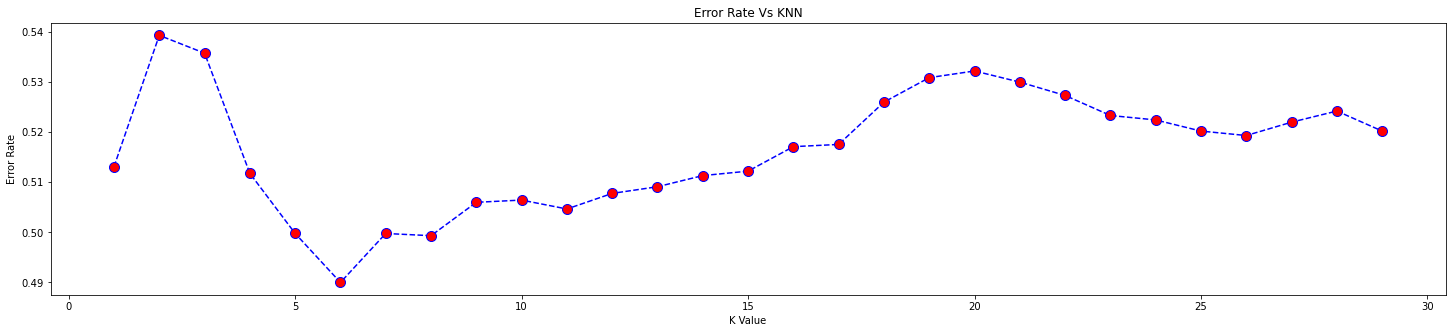

In [77]:
plt.figure(figsize=(25,5))
plt.plot(range(1,30),error_rate,color="blue",linestyle="dashed",marker="o",markerfacecolor="red",markersize=10)
plt.title("Error Rate Vs KNN")
plt.xlabel("K Value")
plt.ylabel("Error Rate")

In [78]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(x_train,y_train)
pred = knn.predict(x_test)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[ 12   2   0   0   1   0   0   1   1   1   0   1   0   0   1   0   2   0
    0   0   1   6]
 [  2 197   2   0   0  23   0  32   1   0   0   0  15   0  19   0  18  13
    0   0  17   2]
 [  0   1  32   0   0   0   0   8   1   0   0   0   0   0   5   0   1   3
    0   0   4   5]
 [  0   0   0   0   3   0   0   1   0   1   0   0   0   0   0   0   0   0
    0   0   0   1]
 [  0   0   0   0   0   0   0   0   0   2   0   0   0   0   1   0   5   0
    0   0   2   0]
 [  1  18   3   0   0  99   0  21   2   0   0   0  10   0   9   2   2   3
    0   0  14   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0
    1   0   0   0]
 [  1  17   1   0   0  10   0 156   0   0   0   0  13   0  38   0  10  11
    0   0  18   3]
 [  6   1   0   0   0   3   0   2   7   4   0   1   1   0   1   4   1   0
    0   0   0   0]
 [  1   2   0   0   0   0   0   3   0   8   0   0   0   0   1   0   1   0
    0   0   0   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
